## Import Libraries

Task 6 will have separate import section


Using Python 3.14, ipykernel 6.30.1

In [47]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score, accuracy_score
from sklearn.discriminant_analysis import StandardScaler
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import RandomOverSampler
from sklearn.impute import KNNImputer
import shap # Version: 0.50.0

# Pandas show all columns
pd.set_option('display.max_columns', None)

# SHAP init
shap.initjs()

## Utils

From utils.py

For data imputation, there are various methods available such as imputing with 0, mean or median, replace value based on groups or using ML-based method to predict the data.
Here, ML-based KNN imputation is used.

In [48]:
class DataLoader():
    def __init__(self):
        self.data = None

    def load_dataset(self, path="data/healthcare-dataset-stroke-data.csv"):
        self.data = pd.read_csv(path)

    def preprocess_data(self):
        # One-hot encode all categorical columns
        categorical_cols = ["gender",
                            "ever_married",
                            "work_type",
                            "Residence_type",
                            "smoking_status"]

        encoded = pd.get_dummies(self.data[categorical_cols], 
                                prefix=categorical_cols)

        # Update data with new columns
        self.data = pd.concat([encoded, self.data], axis=1)
        self.data.drop(categorical_cols, axis=1, inplace=True)

        columns = self.data.columns
        imputer = KNNImputer(n_neighbors=5)
        self.data[columns] = pd.DataFrame(imputer.fit_transform(self.data))
        
        # Drop id as it is not relevant
        self.data.drop(["id"], axis=1, inplace=True)

    def get_data_split(self, should_standardize=False):
        X = self.data.iloc[:,:-1]
        y = self.data.iloc[:,-1]
        
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=0.20, random_state=2021)
        
        if should_standardize:
            continuous_cols = ["age", "avg_glucose_level", "bmi"]

            scaler = StandardScaler()
            X_train[continuous_cols] = scaler.fit_transform(
                X_train[continuous_cols])
            X_test[continuous_cols] = scaler.transform(
                X_test[continuous_cols])

        return X_train, X_test, y_train, y_test
            
    
    def oversample(self, X_train, y_train):
        # Store original column types to restore later
        original_dtypes = X_train.dtypes

        oversample = RandomOverSampler(sampling_strategy='minority')
        # Convert to numpy and oversample
        x_np = X_train.to_numpy()
        y_np = y_train.to_numpy()
        x_np, y_np = oversample.fit_resample(x_np, y_np)
        # Convert back to pandas
        x_over = pd.DataFrame(x_np, columns=X_train.columns)
        y_over = pd.Series(y_np, name=y_train.name)

        # Restore original dtypes
        for col in x_over.columns:
            try:
                x_over[col] = x_over[col].astype(original_dtypes[col])
            except KeyError:
                pass

        return x_over, y_over


## Task 1: Exploratory Data Analysis

Taken from 00_data_exploration.py

Show data head

In [49]:
# Load data
data_loader = DataLoader()
data_loader.load_dataset()
data = data_loader.data

print(data.shape)
data.head()

(5110, 12)


,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


Show general statistics

In [50]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 5110 non-null   int64  
 1   gender             5110 non-null   object 
 2   age                5110 non-null   float64
 3   hypertension       5110 non-null   int64  
 4   heart_disease      5110 non-null   int64  
 5   ever_married       5110 non-null   object 
 6   work_type          5110 non-null   object 
 7   Residence_type     5110 non-null   object 
 8   avg_glucose_level  5110 non-null   float64
 9   bmi                4909 non-null   float64
 10  smoking_status     5110 non-null   object 
 11  stroke             5110 non-null   int64  
dtypes: float64(3), int64(4), object(5)
memory usage: 479.2+ KB


Histograms for all columns

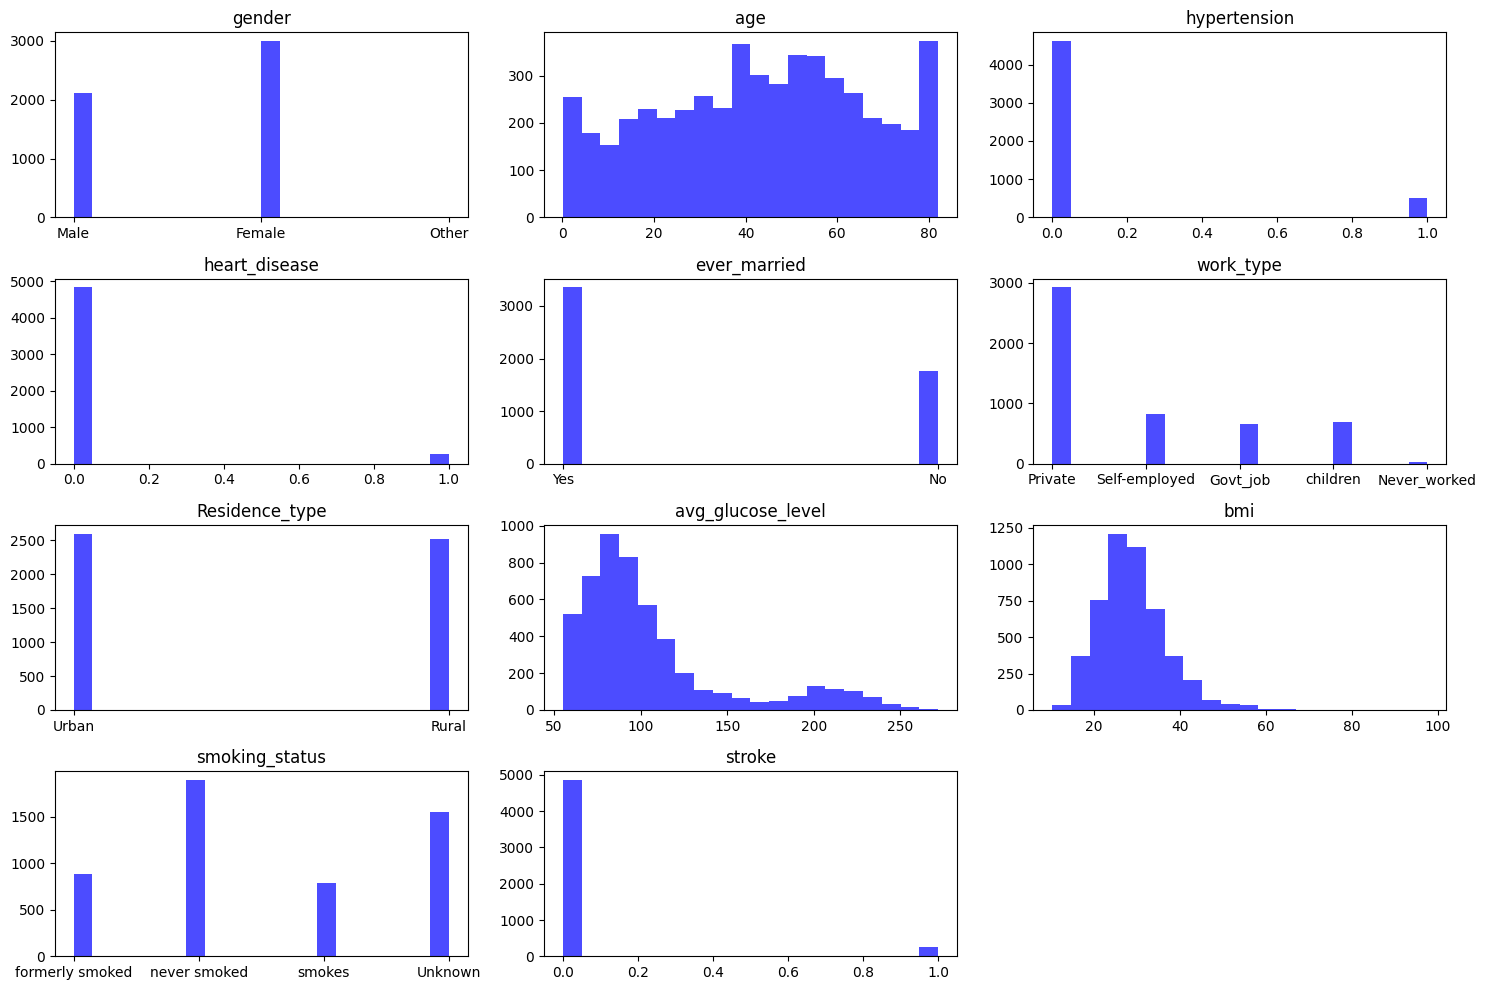

In [51]:
# Show 11 histograms in a 4x3 grid
fig, axs = plt.subplots(4, 3, figsize=(15, 10))
plot_idx = 0
for column in data.columns:
    # Skip showing "id" 
    if column == "id":
        continue
    ax = axs[plot_idx // 3, plot_idx % 3]
    ax.hist(data[column].dropna(), bins=20, color='blue', alpha=0.7)
    ax.set_title(column)
    plot_idx += 1

# Hide the unused last subplot
axs[3, 2].axis('off')

plt.tight_layout()
plt.show()

### Preprocess the data

In [52]:
data_loader = DataLoader()
data_loader.load_dataset()
data_loader.preprocess_data()
data = data_loader.data

X_train, X_test, y_train, y_test = data_loader.get_data_split(should_standardize=False)

# Oversample the train data
X_train, y_train = data_loader.oversample(X_train, y_train)

print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)
data.info()

(7778, 21) (1022, 21) (7778,) (1022,)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 22 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   gender_Female                   5110 non-null   float64
 1   gender_Male                     5110 non-null   float64
 2   gender_Other                    5110 non-null   float64
 3   ever_married_No                 5110 non-null   float64
 4   ever_married_Yes                5110 non-null   float64
 5   work_type_Govt_job              5110 non-null   float64
 6   work_type_Never_worked          5110 non-null   float64
 7   work_type_Private               5110 non-null   float64
 8   work_type_Self-employed         5110 non-null   float64
 9   work_type_children              5110 non-null   float64
 10  Residence_type_Rural            5110 non-null   float64
 11  Residence_type_Urban            5110 non-null   float64
 

## Task 2: Create XAI explainer

### Train a black box model

For task 2, using Random Forest

In [104]:
model = RandomForestClassifier(n_estimators=250, random_state=13)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f"Accuracy: {accuracy:.4f}")
print(f"F1 Score: {f1:.4f}")

Accuracy: 0.9432
F1 Score: 0.0938


### Using SHAP Tree Explainer

In [105]:
shap_explainer = shap.TreeExplainer(model)
shap_values = shap_explainer.shap_values(X_test)

print(shap_values.shape)  # Original shape (Samples, features, output classes)

(1022, 21, 2)


In [106]:
# Change the shape of shap_values to (classes, samples, features)
shap_values = np.array(shap_values)
shap_values = np.transpose(shap_values, (2, 0, 1))

print(shap_values.shape)  # New shape
print(shap_values[1].shape)  # For class 1

(2, 1022, 21)
(1022, 21)


## Task 3: Visualize local Explainer using Force plot

Assuming for a random index

Selected instance index: 332


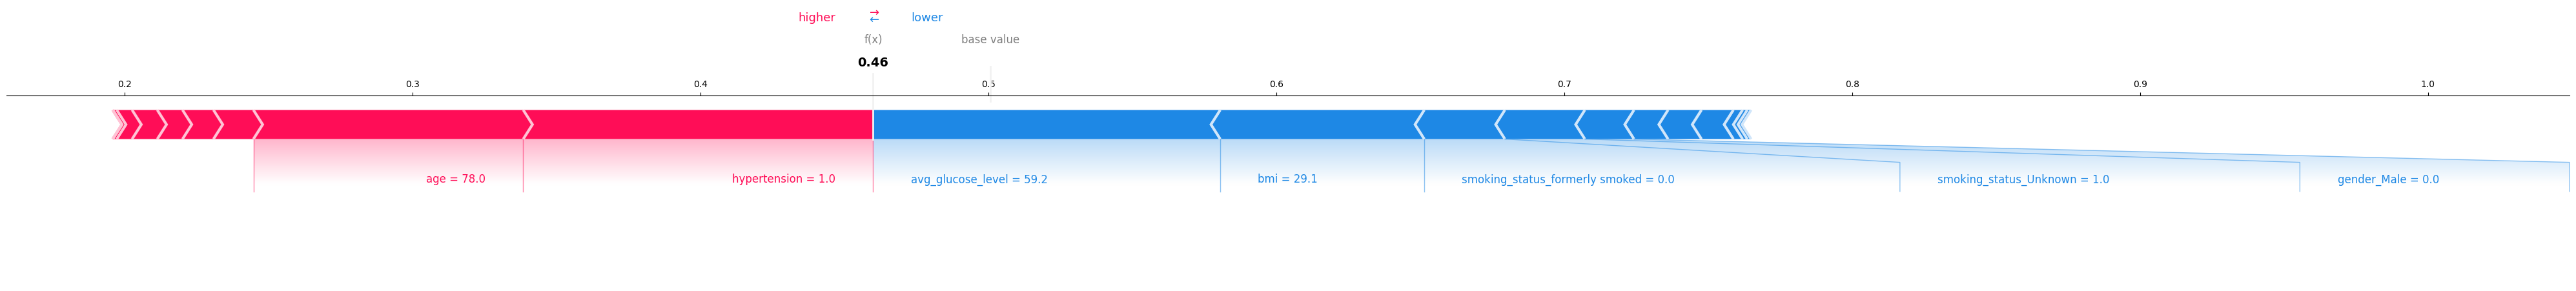

In [112]:
instance_index = np.random.randint(0, X_test.shape[0])
print(f"Selected instance index: {instance_index}") 

shap.force_plot(shap_explainer.expected_value[1], shap_values[1][instance_index,:], X_test.iloc[instance_index,:], matplotlib=True, show=False)

# Make the plot larger
plt.gcf().set_size_inches(40, 5)
plt.tight_layout()
plt.savefig("shap_force_plot.png", dpi=300)
plt.show()

Waterfall plot for slides

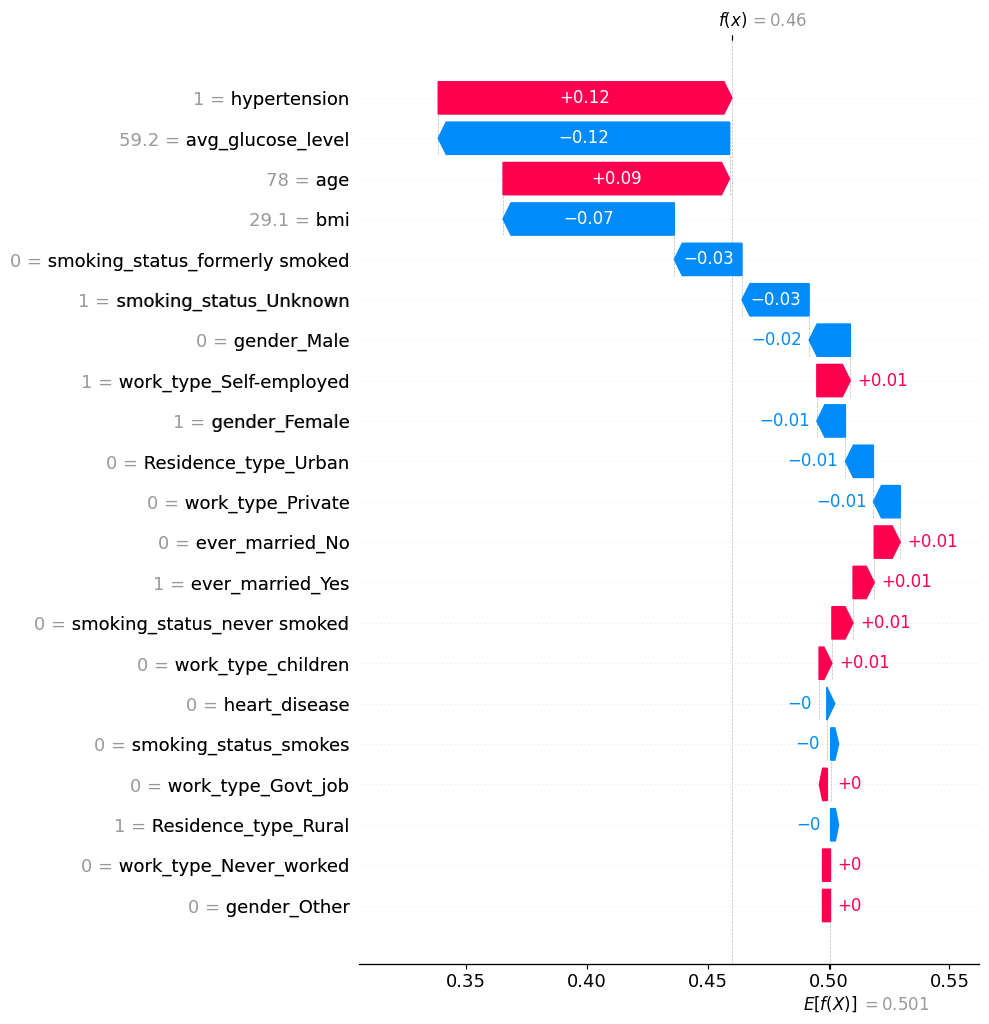

In [113]:
# Create Explanation object for the instance
shap_exp = shap.Explanation(
    base_values=shap_explainer.expected_value[1],
    values=shap_values[1][instance_index, :],
    data=X_test.iloc[instance_index, :],
    feature_names=X_test.columns
)

shap.plots.waterfall(shap_exp, max_display=25, show=False)

plt.savefig('shap_waterfall_plot.png', bbox_inches='tight')
plt.show()

## Task 4: Visualize global Explainer using Summary plot

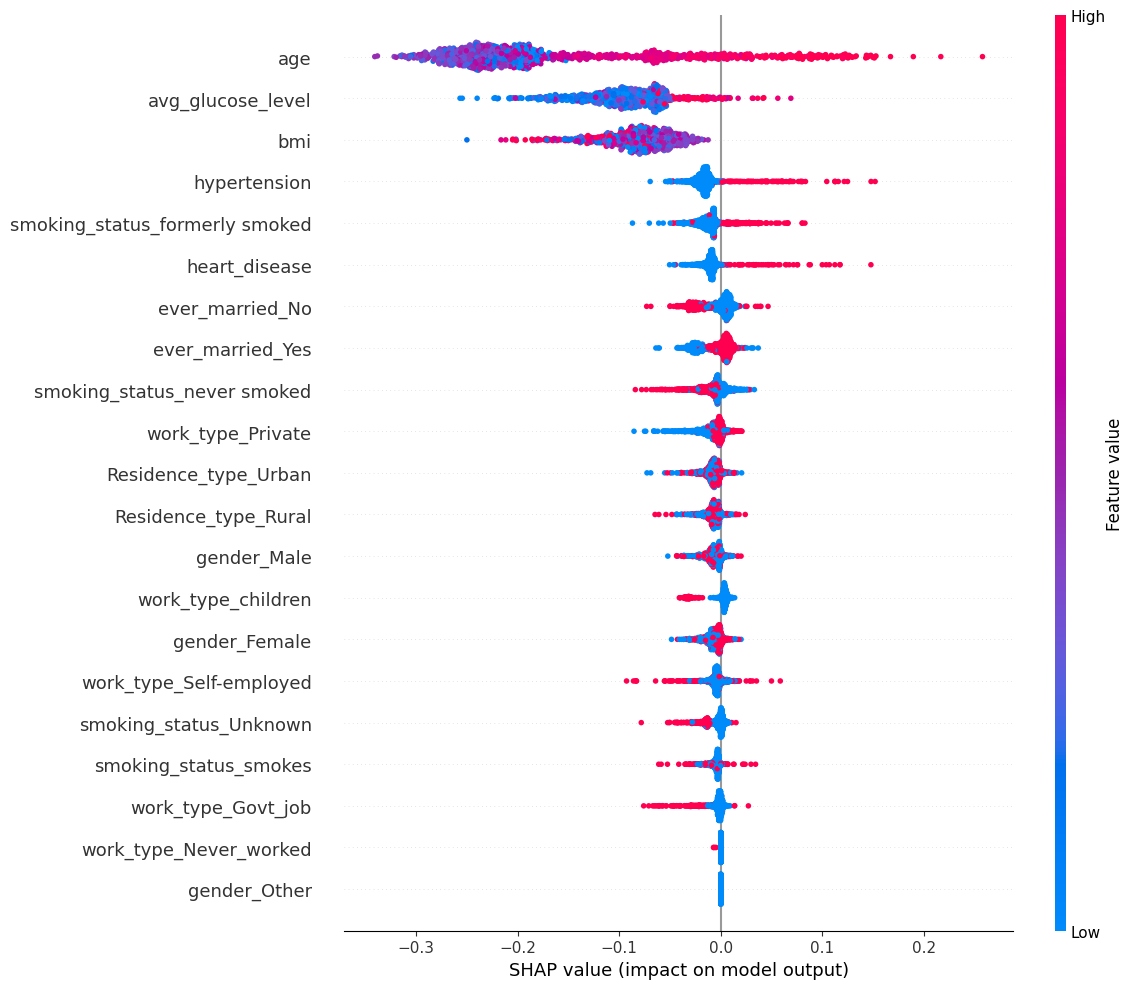

In [109]:
shap.summary_plot(shap_values[1], X_test, show=False, max_display=25)

# Make the plot larger
plt.gcf().set_size_inches(12, 10)
plt.tight_layout()
plt.savefig("shap_summary_plot.png", dpi=300)
plt.show()

## Bonus Task 6: Create Deep SHAP or Kernel SHAP as an explainer and explain a chosen black box model different from Task 2

Using Kernel SHAP with Xgboost and Deep SHAP with a PyTorch Neural Network

### Import libraries for task 6

In [59]:
# For Kernel SHAP
from xgboost import XGBClassifier

# For Deep SHAP
import torch
import torch.nn as nn
import torch.optim as optim

# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


Create Xgboost model

In [60]:
alternative_model = XGBClassifier(n_estimators=250, use_label_encoder=False, eval_metric='logloss', random_state=42)
alternative_model.fit(X_train, y_train)

c:\Users\User\Documents\WQF7009 - xAI\Assignment - SHAP\assignment_shap\Lib\site-packages\xgboost\training.py:199: UserWarning: [21:55:14] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


,objective,'binary:logistic'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,None
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,'logloss'


In [61]:
y_pred_alt = alternative_model.predict(X_test)
accuracy_alt = accuracy_score(y_test, y_pred_alt)
f1_alt = f1_score(y_test, y_pred_alt)

print(f"Alternative Model - Accuracy: {accuracy_alt:.4f}")
print(f"Alternative Model - F1 Score: {f1_alt:.4f}")

Alternative Model - Accuracy: 0.9266
Alternative Model - F1 Score: 0.1935


In [62]:
def model_predict_proba(X):
    return alternative_model.predict_proba(X)

Create Kernel SHAP explainer for the model

In [63]:
n_samples = 100

# Create Kernel SHAP explainer
kernel_explainer = shap.KernelExplainer(
    model=model_predict_proba,
    data=shap.kmeans(X_train, 400)  # Using k-means to summarize background data to reduce computation time
)

# Compute SHAP values for the test set
# Using the full test set takes too long to compute
# kernel_shap_values = kernel_explainer.shap_values(X_test)

# Using fewer instances from the test set to reduce calculation time
kernel_shap_values = kernel_explainer.shap_values(X_test, nsamples=n_samples)

print(kernel_shap_values.shape)

Using 400 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.
100%|██████████| 1022/1022 [00:29<00:00, 34.32it/s]

(1022, 21, 2)


In [64]:
# Change the shape of kernel_shap_values to (classes, samples, features)
kernel_shap_values = np.array(kernel_shap_values)
kernel_shap_values = np.transpose(kernel_shap_values, (2, 0, 1))

print(kernel_shap_values.shape)

(2, 1022, 21)


Selected instance index: 657


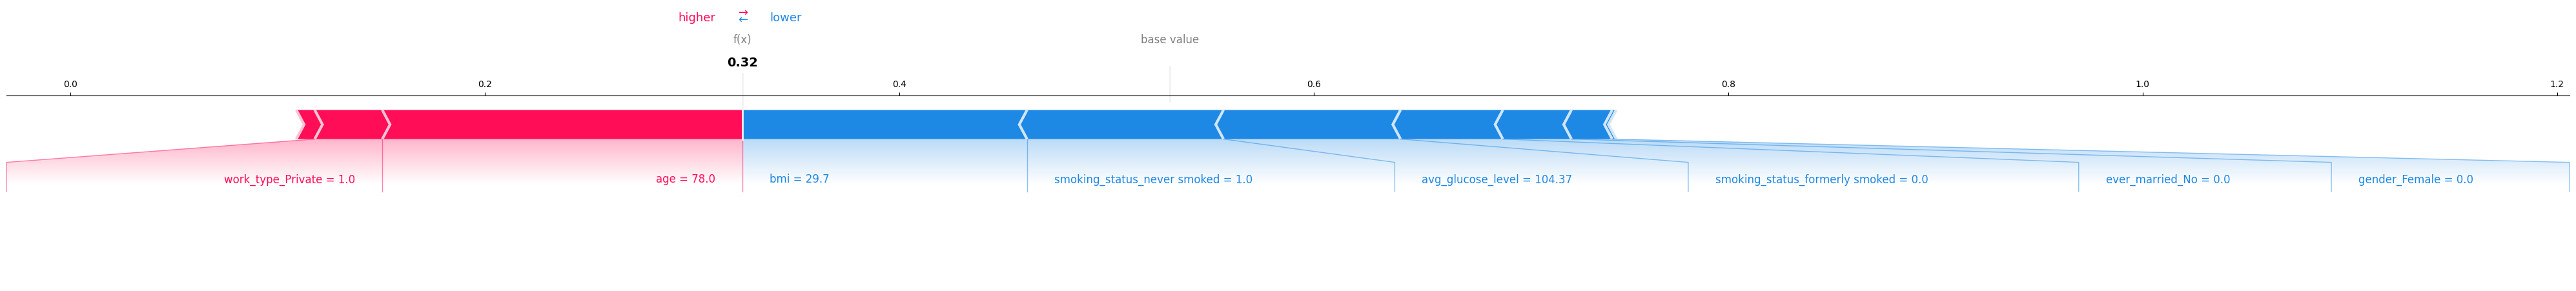

In [129]:
# Randomly select instance index
instance_index = np.random.randint(0, X_test.shape[0])
print(f"Selected instance index: {instance_index}") 

# Show force plot for local explainability
shap.force_plot(kernel_explainer.expected_value[1], kernel_shap_values[1][instance_index,:], X_test.iloc[instance_index,:], matplotlib=True, show=False)

# Make the plot larger
plt.gcf().set_size_inches(40, 5)
plt.tight_layout()
plt.savefig("kernel_shap_force_plot.png", dpi=300)
plt.show()

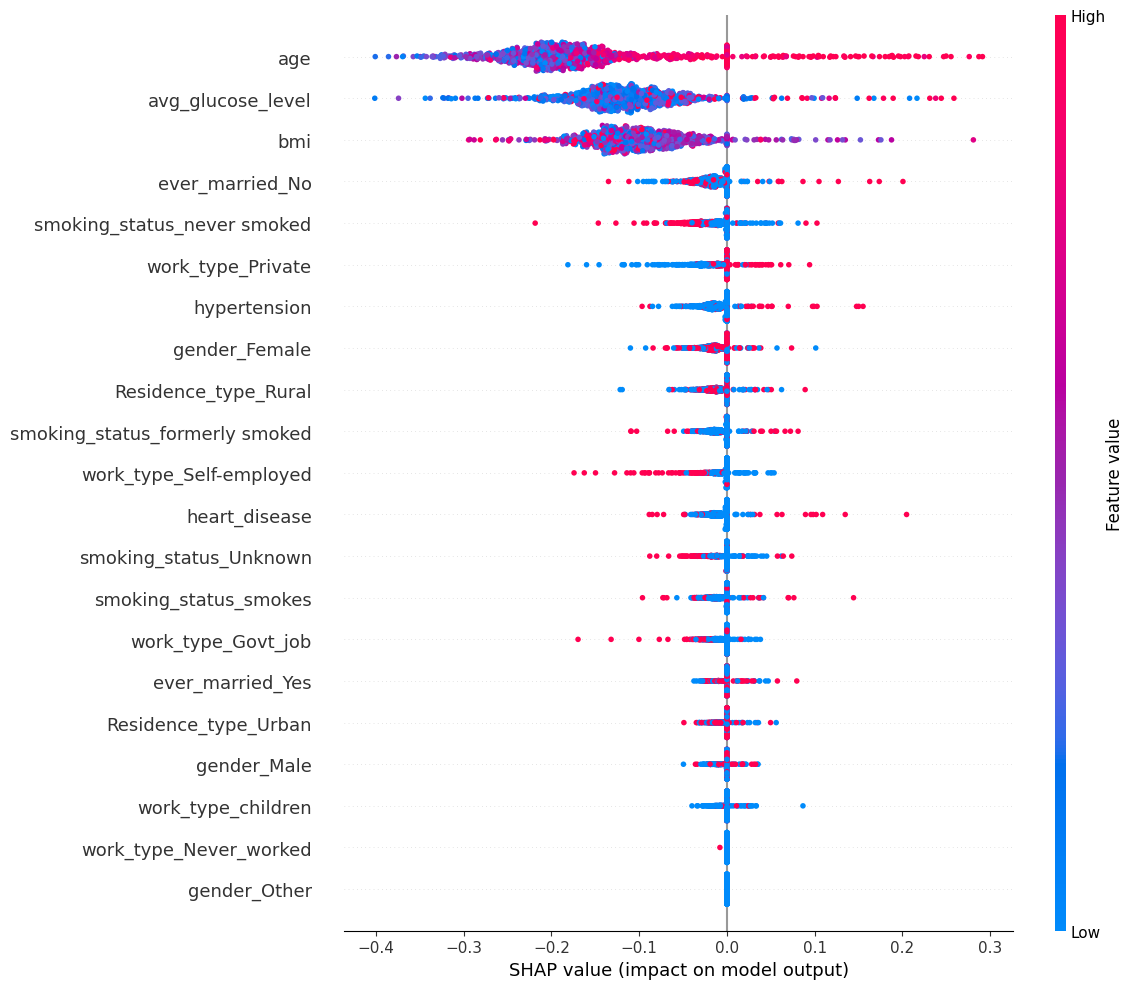

In [66]:
# Show summary plot for class 1
shap.summary_plot(kernel_shap_values[1], X_test, show=False, max_display=25)

# Make the plot larger
plt.gcf().set_size_inches(12, 10)
plt.tight_layout()
plt.savefig("kernel_shap_summary_plot.png", dpi=300)
plt.show()

Using Deep SHAP with a Neural Network

In [185]:
# Simple feedforward neural network
class SimpleNN(nn.Module):
    def __init__(self, input_size):
        super(SimpleNN, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_size, 128),
            nn.ReLU(),
            nn.Linear(128, 32),
            nn.ReLU(),
            nn.Linear(32, 8),
            nn.ReLU(),
            nn.Linear(8, 2)  # Assuming binary classification
        )

    def forward(self, x):
        return self.model(x)

In [186]:
def train_model(model, X_train, y_train, epochs=30, batch_size=64, learning_rate=0.001, device=device):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=0.001)
    model.to(device)

    dataset = torch.utils.data.TensorDataset(X_train, y_train)
    dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)

        epoch_loss = running_loss / len(dataloader.dataset)
        print(f"Epoch {epoch+1}/{epochs}, Loss: {epoch_loss:.4f}")

def evaluate_model(model, X_test, y_test, device=device):
    model.eval()
    X_test, y_test = X_test.to(device), y_test.to(device)

    with torch.no_grad():
        outputs = model(X_test)
        _, predicted = torch.max(outputs, 1)
    accuracy = (predicted == y_test).float().mean().item()
    return accuracy

In [187]:
# Need standardization for Neural Network
data_loader = DataLoader()
data_loader.load_dataset()
data_loader.preprocess_data()
data = data_loader.data

X_train, X_test, y_train, y_test = data_loader.get_data_split(should_standardize=True)

# Oversample the train data
X_train, y_train = data_loader.oversample(X_train, y_train)

In [188]:
# Convert X_train and X_test (pandas DataFrame) to numpy arrays with explicit float type
X_train_np = X_train.astype(float).to_numpy()
X_test_np = X_test.astype(float).to_numpy()

# Convert data to PyTorch tensors
X_train_tensor = torch.tensor(X_train_np, dtype=torch.float32).to(device)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.long).to(device)
X_test_tensor = torch.tensor(X_test_np, dtype=torch.float32).to(device)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.long).to(device)

X_train_tensor.shape, X_test_tensor.shape, y_train_tensor.shape, y_test_tensor.shape

(torch.Size([7778, 21]),
 torch.Size([1022, 21]),
 torch.Size([7778]),
 torch.Size([1022]))

In [189]:
input_size = X_train.shape[1]
model_nn = SimpleNN(input_size).to(device)

# Train the model
train_model(model_nn, X_train_tensor, y_train_tensor, epochs=200, batch_size=64, learning_rate=0.005, device=device)

Epoch 1/200, Loss: 0.4731
Epoch 2/200, Loss: 0.4220
Epoch 3/200, Loss: 0.3896
Epoch 4/200, Loss: 0.3558
Epoch 5/200, Loss: 0.3259
Epoch 6/200, Loss: 0.2961
Epoch 7/200, Loss: 0.2641
Epoch 8/200, Loss: 0.2476
Epoch 9/200, Loss: 0.2377
Epoch 10/200, Loss: 0.2268
Epoch 11/200, Loss: 0.2220
Epoch 12/200, Loss: 0.2083
Epoch 13/200, Loss: 0.2020
Epoch 14/200, Loss: 0.1934
Epoch 15/200, Loss: 0.1815
Epoch 16/200, Loss: 0.1869
Epoch 17/200, Loss: 0.1780
Epoch 18/200, Loss: 0.1639
Epoch 19/200, Loss: 0.1699
Epoch 20/200, Loss: 0.1866
Epoch 21/200, Loss: 0.1534
Epoch 22/200, Loss: 0.1563
Epoch 23/200, Loss: 0.1573
Epoch 24/200, Loss: 0.1467
Epoch 25/200, Loss: 0.1543
Epoch 26/200, Loss: 0.1517
Epoch 27/200, Loss: 0.1433
Epoch 28/200, Loss: 0.1480
Epoch 29/200, Loss: 0.1458
Epoch 30/200, Loss: 0.1356
Epoch 31/200, Loss: 0.1401
Epoch 32/200, Loss: 0.1302
Epoch 33/200, Loss: 0.1273
Epoch 34/200, Loss: 0.1326
Epoch 35/200, Loss: 0.1327
Epoch 36/200, Loss: 0.1475
Epoch 37/200, Loss: 0.1262
Epoch 38/2

In [190]:
# Test the model
test_accuracy = evaluate_model(model_nn, X_test_tensor, y_test_tensor, device=device)
print(f"Neural Network Test Accuracy: {test_accuracy:.4f}")

Neural Network Test Accuracy: 0.8943


In [191]:
# Select a subset of training data for SHAP background
background_size = 2000
background_size_test = 500

background_data = X_train_tensor[torch.randperm(X_train_tensor.size(0))[:background_size]].to(device)
X_test_sample = X_test_tensor[torch.randperm(X_test_tensor.size(0))[:background_size_test]].to(device)

type(background_data), background_data.shape, type(X_test_sample), X_test_sample.shape

(torch.Tensor, torch.Size([2000, 21]), torch.Tensor, torch.Size([500, 21]))

In [192]:
# Create Deep SHAP explainer
deep_explainer = shap.DeepExplainer(model_nn, background_data)

# Compute SHAP values for the test sample
deep_shap_values = deep_explainer.shap_values(X_test_sample)

print(deep_shap_values.shape)

(500, 21, 2)


In [193]:
# Change the shape of deep_shap_values to (classes, samples, features)
deep_shap_values = np.array(deep_shap_values)
deep_shap_values = np.transpose(deep_shap_values, (2, 0, 1))

print(deep_shap_values.shape)

(2, 500, 21)


Selected instance index: 403


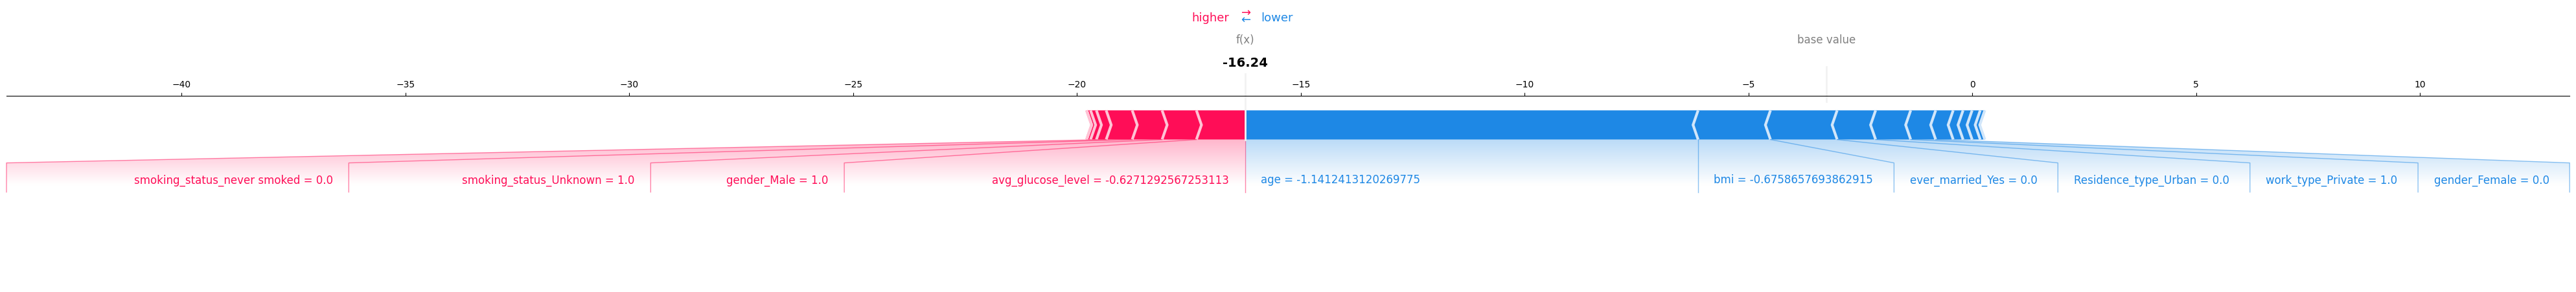

In [194]:
# Randomly select instance index
instance_index = np.random.randint(0, background_size_test)
print(f"Selected instance index: {instance_index}") 

# Show force plot for local explainability
shap.force_plot(
    deep_explainer.expected_value[1],
    deep_shap_values[1][instance_index,:],
    X_test_sample.cpu().numpy()[instance_index,:],
    feature_names=X_test.columns,
    matplotlib=True,
    show=False
)

# Make the plot larger
plt.gcf().set_size_inches(40, 5)
plt.tight_layout()
plt.savefig("deep_shap_force_plot.png", dpi=300)
plt.show()

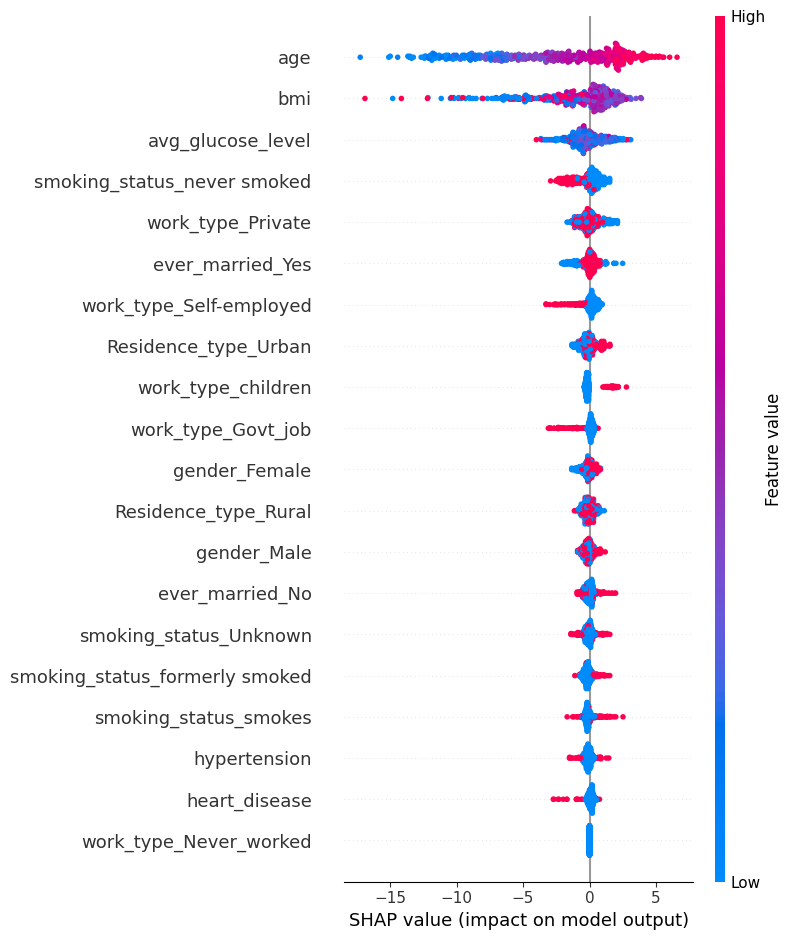

<Figure size 1200x1000 with 0 Axes>

In [195]:
# Show summary plot for class 1
shap.summary_plot(
    shap_values=deep_shap_values[1],
    features=X_test_sample.cpu().numpy(),
    feature_names=X_test.columns
)

# Make the plot larger
plt.gcf().set_size_inches(12, 10)
plt.tight_layout()
plt.savefig("deep_shap_summary_plot.png", dpi=300)
plt.show()